In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_dir = "/content/gdrive/My Drive/MachineLearning/PlantIll/"
base_dir = root_dir + 'DPModel'

In [0]:
!pip install -q torch==1.0.0 torchvision

     |████████████████████████████████| 591.8MB 30kB/s 
ERROR: torchvision 0.4.1+cu100 has requirement torch==1.3.0, but you'll have torch 1.0.0 which is incompatible.


In [0]:
from fastai import *
from fastai.vision import *
from fastai.widgets import *
import torchvision.models as TorchModels

In [0]:
%reload_ext autoreload 
%autoreload 2
%matplotlib inline 

In [0]:
#change directory to where we have our project
import os 
os.getcwd() 
os.chdir('/content/gdrive/My Drive/MachineLearning/PlantIll') 

# Getting the data

In [0]:
## our datapath
path = Path('/content/gdrive/My Drive/Datasets/PlantVillage')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [0]:
path.ls()

[PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/val'),
 PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/train'),
 PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/models'),
 PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/tmp.pth')]

In [0]:
##### Data **augmentation** 
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src  = ImageList.from_folder(path)

In [0]:
src.items[0]

PosixPath('/content/gdrive/My Drive/Datasets/PlantVillage/val/Apple___Cedar_apple_rust/7e32ce27-bc89-4fca-9f49-c50de91210d1___FREC_C.Rust 4425.JPG')

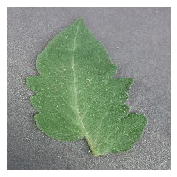

In [0]:
src[110].show()

In [0]:
sd = (src.split_by_folder(train='train', valid='val'))
sd

ItemLists;

Train: ImageList (26022 items)
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /content/gdrive/My Drive/Datasets/PlantVillage;

Valid: ImageList (6463 items)
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /content/gdrive/My Drive/Datasets/PlantVillage;

Test: None

In [0]:
labellists =(sd.label_from_folder())
labellists

LabelLists;

Train: LabelList (26022 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Potato___Late_blight,Potato___Late_blight,Potato___Late_blight,Potato___Late_blight,Potato___Late_blight
Path: /content/gdrive/My Drive/Datasets/PlantVillage;

Valid: LabelList (6463 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Apple___Cedar_apple_rust,Apple___Cedar_apple_rust,Apple___Cedar_apple_rust,Apple___Cedar_apple_rust,Apple___Cedar_apple_rust
Path: /content/gdrive/My Drive/Datasets/PlantVillage;

Test: None

In [0]:
##batch size 
bs= 20
## we will use it in progrissive resizing at the beggining it was 256//2
img_size = 299

In [0]:
labellists = (labellists.transform(tfms , size=img_size))

In [0]:
## our data bunch, it contains ou data loaders 
data =  labellists.databunch(bs=bs).normalize(imagenet_stats)

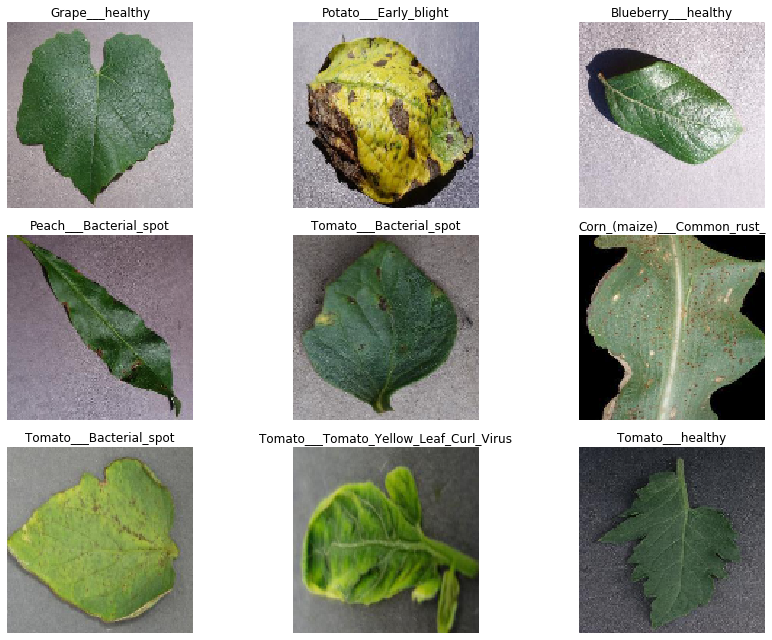

In [0]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
print(data.classes)
len(data.classes),data.c

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

(39, 39)

# Our Model 

In [0]:
inceptionModel = TorchModels.inception_v3(pretrained=True)
nf = data.c # number of output classes in your data

In [0]:
for param in inceptionModel.parameters():
  param.requires_grad = False

In [0]:
#inceptionModel.aux_logit = False

In [0]:
num_ftrs1 = inceptionModel.AuxLogits.fc.in_features
inceptionModel.AuxLogits.fc = nn.Linear(num_ftrs1, nf)
num_ftrs2 = inceptionModel.fc.in_features
inceptionModel.fc = nn.Linear(num_ftrs2, nf)

In [0]:
inceptionModel = inceptionModel.cuda()

In [0]:
#loss=F.cross_entropy
def my_loss(preds,target):
  if isinstance(preds, tuple):
    loss = sum((F.cross_entropy(o,target) for o in preds))
  else:
    loss = F.cross_entropy(preds,target)
  return loss

In [0]:
## fbeta is F1 score fbeta,
learn = Learner(data, inceptionModel, loss_func=my_loss, metrics=accuracy)

beta determines the value of the fbeta applied, eps is there for numeric stability. If sigmoid=True, a sigmoid is applied to the predictions before comparing them to thresh then to the targets. See the https://en.wikipedia.org/wiki/F1_score for details on the fbeta score.

In [0]:
learn.summary()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


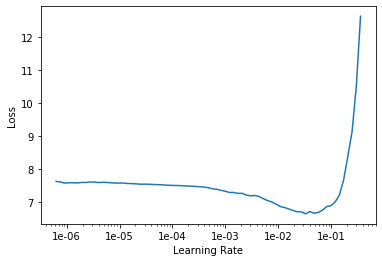

In [0]:
learn.lr_find()
learn.recorder.plot()

# Train the model

In [0]:
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,1.900029,1.066613,0.792047,1:31:58
1,0.890793,0.420341,0.883026,09:16
2,0.781353,0.327399,0.899273,09:23
3,0.824496,0.287502,0.914745,09:08
4,0.713757,0.252932,0.922637,09:06
5,0.618118,0.238045,0.924803,09:03
6,0.640123,0.238584,0.924803,09:03


In [0]:
#learn.save('weight-iceptionV3-1')

Plotting Losses


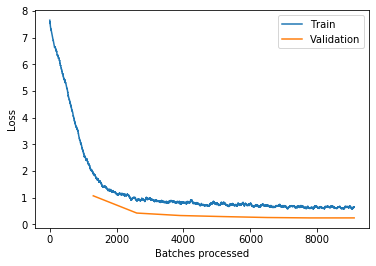

In [0]:
print("Plotting Losses")
learn.recorder.plot_losses()


Plotting metrics


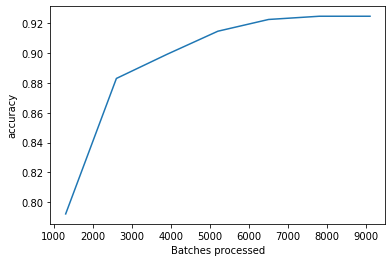

In [0]:
print("Plotting metrics")
learn.recorder.plot_metrics()


Plotting LR


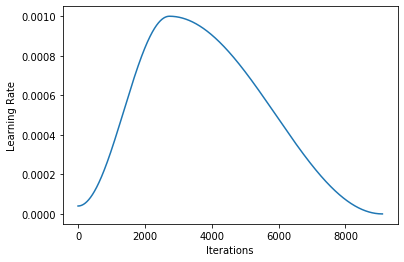

In [0]:
print("Plotting LR")
learn.recorder.plot_lr()

In [0]:
learn.load('weight-iceptionV3-1');

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.824790,0.329324,0.908711,19:12
1,0.690353,0.459281,0.852545,19:11
2,0.376044,0.143205,0.952963,19:11
3,0.222877,0.128316,0.958997,19:09
4,0.116882,0.031677,0.989788,19:09
5,0.079123,0.024234,0.992883,19:10
6,0.034356,0.019043,0.994894,19:09


In [0]:
#learn.save('weight-iceptionV3-2')

In [0]:
learn.load('weight-iceptionV3-2');

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-1))

In [0]:
learn.save('weight-iceptionV3-3')

In [0]:
learn.load('weight-iceptionV3-3');

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-1))

In [0]:
learn.save('weight-iceptionV3-4')

In [0]:
learn.load('weight-iceptionV3-4');

In [0]:
learn.unfreeze()
learn.fit_one_cycle(7, max_lr=slice(1e-3, 1e-1))

In [0]:
learn.save('weight-iceptionV3-5')